In [1]:
# get the paths to the code sorted out.  This is the wrong way to do it, and it needs sorting out as to the correct way
# Might need pip install developer mode so that a symlink is made to the databakersolo source code from the git checkout
# rather than it being copied deep into the site-packages directory tree
import sys
sys.path.insert(0, "/home/goatchurch/sensiblecode/databaker")
sys.path.insert(0, "/home/goatchurch/sensiblecode/xypath")
sys.path.insert(0, "/home/goatchurch/sensiblecode/messytables")
sys.path.insert(0, "/home/goatchurch/datalogging/anaconda3/lib/python3.5/site-packages/")  # for xlrd
sys.path.insert(0, "/home/goatchurch/datalogging/anaconda3/lib/python3.5/site-packages/xlutils-2.0.0-py3.5.egg/")  # for xlutils
import databaker
import databaker.constants
import xlutils
import xypath



In [2]:
# The following is a block of code copied directly from an actual recipe without any changes

from databaker.constants import *

def per_file(tabs):    
    return PARAMS(0)

def per_tab(tab):           
     
    my_dict = {"6A_Top": 'CBAQ', "6A_Bottom": 'HCL3', "6D_Top": 'CBAS', "6D_Bottom":'HCL5',
               "7A_Top": 'CBAU', "7A_Bottom": 'HCK7', "7D_Top": 'CBAW', "7D_Bottom":'HCK9',
    }

    anchor = tab.filter(contains_string (my_dict[PARAMS(1)]))
    obs = anchor.shift(DOWN).expand(RIGHT).expand(DOWN).is_not_blank()

    # Getting all the junk out of the file
    unwanted = tab.excel_ref('AA1').expand(DOWN).expand(RIGHT)     
    unwanted = unwanted | anchor.expand(DOWN).filter(contains_string ('Area Analysis')).expand(RIGHT).expand(DOWN)
    unwanted = unwanted | tab.filter(contains_string ('indicates earliest revision')).expand(RIGHT).expand(DOWN)
    unwanted = unwanted | anchor.expand(DOWN).filter(contains_string ('Number')).shift(UP).expand(RIGHT).expand(DOWN)
    obs = obs - unwanted    
    
    # Dimension etc
    anchor.shift(0, -2).expand(RIGHT).is_not_blank().dimension("Area", CLOSEST, LEFT)
    anchor.shift(0, -1).expand(RIGHT).is_not_blank().dimension(MEASURETYPE, DIRECTLY, ABOVE)
    anchor.shift(-1, 0).expand(DOWN).is_not_blank().dimension(TIME, DIRECTLY, LEFT)        
    
    cat = tab.filter(contains_string (PARAMS(1)[0:2])).shift(RIGHT)
    cat.dimension("Mergers", CLOSEST, ABOVE)

    tab.dimension("Companies", "TempValue")
    
    yield obs



In [3]:
# this is a set of parameters copied from a command in the batch file
sys.argv = ["Mergers_6_7_recipe.py", "--preview", "rftmatables_tcm77-415727.xls", "Table 6", "6A_Top"]


In [4]:
import databaker.databakersolo as ds
Opt = ds.Options()
ds.Globrecipeper_file = per_file
ds.Globrecipeper_tab = per_tab
databaker.utils.showtime_enabled = Opt.timing
databaker.constants.constant_params = Opt.params


In [5]:
# The following loop works (if there are multiple files), but here there is almost always only one, 
# so we are going to unroll it and inline the big DBSper_fileFUNC() function
#for fn in Opt.xls_files:
#    ds.DBSper_fileFUNC(fn, Opt)
spreadsheet = Opt.xls_files[0]


In [6]:
# Load in the table set and apply the given recipe.per_file() filter
tableset = xypath.loader.table_set(spreadsheet, extension='xls')
tabsfilter = per_file(tableset)   # function from the recipe
tabs = list(xypath.loader.get_sheets(tableset, tabsfilter))   
print("The list table names is", [ tab.name  for tab in tabs ])

# This concludes the business of the per_file() recipe function


The list table names is ['Table 6']


In [7]:
# Now we unroll the blocks of "yields" of segments given in the recipe.per_tab() function

conversionsegments = [ ]   # [ (tab, {int:dimension}, [obs]) ]
for tab in tabs:
    segmentgenerator = per_tab(tab)   # function from recipe
    if isinstance(segmentgenerator, xypath.xypath.Bag):
        segmentgenerator = [segmentgenerator]    # backward compatibility for return cases

    for segment in segmentgenerator:  # must be yielded so we can copy out tab.headers which are set between the function calls
        assert tab.headernames == [None]+[tab.headers[i].Dlabel  for i in range(1, max(tab.headers.keys())+1)]  # prove we can recreate the data
        conversionsegments.append((tab, tab.headers, segment))
        tab.headers, tab.max_header, tab.headernames = {}, 0, [None]  # reset the hidden list of dimensions/headers back to empty before the next block

# This concludes all the business of the per_tab() recipe function


got header Area: 1.988s,  1.988s total
got header MEASURETYPE: 0.000s,  1.988s total
got header TIME: 0.000s,  1.988s total
got header Mergers: 0.003s,  1.991s total
got header Companies: 0.000s,  1.991s total


In [8]:
# Provide a quick summary of the conversions that have been scheduled
for conversionsegment in conversionsegments:
    tab, headers, segment = conversionsegment
    print("'%s':'%s' has %d cells of which %d have been selected" % (spreadsheet, tab.name, len(tab), len(segment)))
    for i, header in sorted(headers.items()):
        label = header.Dlabel
        if isinstance(label, int) and label < 0:
            label = databaker.constants.template.dimension_names[-label+1]
        print("    Dim:%d '%s' has %d headercells and is looked up in the %s direction strict=%s" % (i, label, len(header.bag), str(header.direction), header.strict))


'rftmatables_tcm77-415727.xls':'Table 6' has 2176 cells of which 100 have been selected
    Dim:-6 'TIME' has 10 headercells and is looked up in the (0, -1) direction strict=True
    Dim:-2 'MEASURETYPE' has 46 headercells and is looked up in the (-1, 0) direction strict=True
    Dim:1 'Area' has 5 headercells and is looked up in the (-1, 0) direction strict=False
    Dim:2 'Mergers' has 1 headercells and is looked up in the (0, -1) direction strict=False
    Dim:3 'Companies' has 2176 headercells and is looked up in the None direction strict=None


In [9]:
# This code block produces the preview spreadsheet if required.  
# We could intervene and plot the values of headers in an array to show how they are lining up
if Opt.preview:
    writer = xlutils.copy.copy(tableset.workbook)
    previewfilename = ds.filenames(spreadsheet, Opt)['preview']
    writer.save(previewfilename)
    for tab, headers, segment in conversionsegments:
        tableset = xypath.loader.table_set(previewfilename, extension='xls')   # load and save between each one
        writer = xlutils.copy.copy(tableset.workbook)
        ds.make_preview(writer, tab.index, headers, segment)
    print("Saving preview file '%s'" % previewfilename)
    writer.save(previewfilename)


Saving preview file 'preview-rftmatables_tcm77-415727-Mergers_6_7_recipe-Table 6,6A_Top.xls'


In [10]:
# We now do the conversions from the observations to the headers (This is the slow part)
batchrows = [ ]
for tab, headers, segment in conversionsegments:
    headernames = [None]+[headers[i].Dlabel  for i in range(1, max(headers)+1)]  # recreate value used in output conversion
    for ob_num, ob in enumerate(segment):
        values = ds.extract_dimension_values_for_ob(headers, ob, Opt.no_lookup_error)
        batchrows.append((values, headernames))
len(batchrows)

/home/goatchurch/sensiblecode/databaker/databaker/utils.py:47: UserWarning: Couldn't identify date '2010²'
  warnings.warn("Couldn't identify date {!r}".format(date))


100

In [11]:
# This is the final stage for outputting the bloated csv file
csv_file = ds.filenames(spreadsheet, Opt)['csv']
csv = ds.TechnicalCSV(csv_file, Opt.no_lookup_error)

# write the headers put out in the file
tab, headers, segment = conversionsegments[0]
headernames = [None]+[headers[i].Dlabel  for i in range(1, max(headers)+1)]  # recreate value used in output conversion
headerrow = csv.generate_header_row(headers, headernames)
csv.csv_writer.writerow(headerrow)  # note that only first batch of headernames is used

print("Outputting file '%s' with %d lines" % (csv_file, len(batchrows)))
#print("The headerrow is:", headerrow)

# this spits out the actual rows
for values, headernames in batchrows:
    output_row = ds.yield_dimension_values(values, headernames)
    csv.output(output_row)
csv.footer()   # this closes the file

# And we're done

Outputting file 'data-rftmatables_tcm77-415727-Mergers_6_7_recipe-Table 6,6A_Top.csv' with 100 lines


In [12]:
# HTML preview of the dimensions and table (will be moved to a function in databakersolo)

from IPython.display import display
from IPython.core.display import HTML

def tsubsets(headers, segment):
    tsubs = [ ]
    if segment:
        tsubs.append((OBS, "OBS", segment))
    for i, header in headers.items():
        if header.direction is not None:   # filter out TempValue headers
            label = header.Dlabel
            if isinstance(label, int) and label < 0:
                label = databaker.constants.template.dimension_names[-label+1]
            tsubs.append((i, label, header.bag))
    return tsubs

def displaytable(tab, tsubs):
    key = [ ]
    key.append('<table class="ex">\n')
    key.append('<tr>')
    ixyheaderlookup = { }
    for i, label, bag in tsubs:
        for h in bag:
            ixyheaderlookup[(h.x, h.y)] = i
        key.append('<td class="exc%d">' % i)
        key.append(label)
        key.append('</td>')
    key.append('</tr>')
    key.append('</table>\n')

    colchange = {"rose":"misty_rose", "ice_blue":"cornflower_blue", "periwinkle":"burly_wood", "pale_blue":"deep_sky_blue", "gray25":"light_gray", "light_turquoise":"pale_turquoise"}

    sty = [ ]
    sty.append("<style>\n")
    sty.append("table.ex td, table.ex tr { border: none }\n")
    sty.append("td.exbold { font-weight: bold }\n")
    sty.append("td.exnumber { color: green }\n")
    sty.append("td.exdate { color: purple }\n")
    for i, col in ds.colourlist.items():
        sty.append("td.exc%d { background-color: %s }\n" % (i, "".join(lv.capitalize() for lv in colchange.get(col, col).split("_"))))
    sty.append("</style>\n\n")

    htm = [ ]
    htm.append('<table class="ex">\n')
    for row in tab.rows():
        htm.append("<tr>")
        assert len(row) == tab._max_x + 1
        rrow = sorted(row, key=lambda X: X.x)
        for c in rrow:
            cs = [ ]
            ih = ixyheaderlookup.get((c.x, c.y))
            if ih is not None:             cs.append("exc%d" % ih)
            if c.properties.get_bold():    cs.append("exbold")
            if c.is_date():                cs.append("exdate")
            if c.is_number():              cs.append("exnumber")
            htm.append('<td class="%s">' % " ".join(cs))
            htm.append(str(c.value))
            htm.append("</td>")
        htm.append("</tr>\n")
    htm.append("</table>\n")

    display(HTML("".join(sty)))
    display(HTML("".join(key)))
    display(HTML("".join(htm)))

tab, headers, segment = conversionsegments[0]
displaytable(tab, tsubsets(headers, segment))



OBS,Area,TIME,Mergers,MEASURETYPE


,6A,Area Analysis of Acquisitions Abroad by UK Companies,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,£ million,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,World Total,,,,,EU1,,,,,Other Europe,,,,,Europe Total,,,,,USA,,,,,,,,,
,,Number,,Value,,,Number,,Value,,,Number,,Value,,,Number,,Value,,,Number,,Value,,,,,,,
,,CBAQ,,CBBI,,,CBAY,,CBAZ,,,HCK3,,HCK4,,,HCJ3,,HCJ4,,,CBBA,,CBBB,,,,,,,
,2005.0,365.0,,32732.0,,,157.0,,5056.0,,,18.0,,1766.0,,,175.0,,6822.0,,,112.0,,15683.0,,,,,,,
,2006.0,405.0,,37412.0,,,131.0,,12966.0,,,39.0,,5962.0,,,170.0,,18928.0,,,138.0,,7348.0,,,,,,,
,2007.0,441.0,,57814.0,,,170.0,,7397.0,,,29.0,,1062.0,,,199.0,,8459.0,,,115.0,,21676.0,,,,,,,
,2008.0,298.0,,29670.0,,,102.0,,13613.0,,,29.0,,1720.0,,,131.0,,15333.0,,,88.0,,7244.0,,,,,,,
,2009.0,118.0,,10148.0,,,36.0,,1800.0,,,8.0,,169.0,,,44.0,,1969.0,,,34.0,,3250.0,,,,,,,
,2010²,199.0,,12414.0,,,66.0,,2979.0,,,18.0,,471.0,,,84.0,,3450.0,,,53.0,,6223.0,,,,,,,


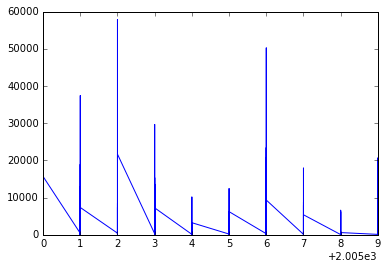

In [41]:
%matplotlib inline

# restate the recipe and the batch file code that calls it in order to start compressing it down
# 

my_dict = {"6A_Top": 'CBAQ', "6A_Bottom": 'HCL3', "6D_Top": 'CBAS', "6D_Bottom":'HCL5',
           "7A_Top": 'CBAU', "7A_Bottom": 'HCK7', "7D_Top": 'CBAW', "7D_Bottom":'HCK9',
}


anchor = tab.filter(contains_string("CBAQ"))
obs = anchor.shift(DOWN).expand(RIGHT).expand(DOWN).is_not_blank()

# Getting all the junk out of the file
unwanted = tab.excel_ref('AA1').expand(DOWN).expand(RIGHT)     
unwanted = unwanted | anchor.expand(DOWN).filter(contains_string ('Area Analysis')).expand(RIGHT).expand(DOWN)
unwanted = unwanted | tab.filter(contains_string ('indicates earliest revision')).expand(RIGHT).expand(DOWN)
unwanted = unwanted | anchor.expand(DOWN).filter(contains_string ('Number')).shift(UP).expand(RIGHT).expand(DOWN)
obs = obs - unwanted    

"""
bake --preview Mergers_6_7_recipe.py rftmatables_tcm77-415727.xls "Table 6" "6A_Top"
bake --preview Mergers_6_7_recipe.py rftmatables_tcm77-415727.xls "Table 6" "6A_Bottom"
bake --preview Mergers_6_7_recipe.py rftmatables_tcm77-415727.xls "Table 6" "6D_Top"
bake --preview Mergers_6_7_recipe.py rftmatables_tcm77-415727.xls "Table 6" "6D_Bottom"
bake --preview Mergers_6_7_recipe.py rftmatables_tcm77-415727.xls "Table 7" "7A_Top"
bake --preview Mergers_6_7_recipe.py rftmatables_tcm77-415727.xls "Table 7" "7A_Bottom"
bake --preview Mergers_6_7_recipe.py rftmatables_tcm77-415727.xls "Table 7" "7D_Top"
bake --preview Mergers_6_7_recipe.py rftmatables_tcm77-415727.xls "Table 7" "7D_Bottom"


# Dimension etc
anchor.shift(0, -2).expand(RIGHT).is_not_blank().dimension("Area", CLOSEST, LEFT)
anchor.shift(0, -1).expand(RIGHT).is_not_blank().dimension(MEASURETYPE, DIRECTLY, ABOVE)
anchor.shift(-1, 0).expand(DOWN).is_not_blank().dimension(TIME, DIRECTLY, LEFT)        


cat = tab.filter(contains_string (PARAMS(1)[0:2])).shift(RIGHT)
cat.dimension("Mergers", CLOSEST, ABOVE)

#displaytable(tab, [(1, "anchor", obs)])

ds.overrides.Dcelllookup()

hcell = Dcelllookup(self.bag, self.direction, self.strict, hcells, scell)

"""


Lobs = list(obs)
Pd = {"OBS":Lobs}
# anchor.shift(0, -2).expand(RIGHT).is_not_blank().dimension("Area", CLOSEST, LEFT)
Pd["area"] = [ ds.overrides.Dcelllookup(anchor.shift(0, -2).expand(RIGHT).is_not_blank(), LEFT, CLOSEST, None, scell)  for scell in Lobs]
# anchor.shift(0, -1).expand(RIGHT).is_not_blank().dimension(MEASURETYPE, DIRECTLY, ABOVE)
Pd["MEASURETYPE"] = [ ds.overrides.Dcelllookup(anchor.shift(0, -1).expand(RIGHT).is_not_blank(), ABOVE, DIRECTLY, None, scell)  for scell in Lobs]
#anchor.shift(-1, 0).expand(DOWN).is_not_blank().dimension(TIME, DIRECTLY, LEFT)        
Pd["TIME"] = [ ds.overrides.Dcelllookup(anchor.shift(-1, 0).expand(DOWN).is_not_blank(), LEFT, DIRECTLY, None, scell)  for scell in Lobs]

Pd["cat"] = [ ds.overrides.Dcelllookup(tab.filter(contains_string ("6A")).shift(RIGHT), ABOVE, CLOSEST, None, scell)  for scell in Lobs]

Pd = dict((k, [v.value  for v in L])  for k, L in Pd.items())
Pd["TIME"] = [int(v[:4]) if isinstance(v, str) else v  for v in Pd["TIME"]]
Pd["OBS"] = [0 if isinstance(v, str) else v  for v in Pd["OBS"]]
import pandas
#help(pandas.DataFrame)
pandas.DataFrame(Pd)

import matplotlib.pyplot as plt
plt.plot(Pd["TIME"], Pd["OBS"])
#Pd["TIME"]
#Pd["OBS"]


In [373]:
ds.overrides.Dimension

databaker.overrides.Dimension